## DataChallenge MDI341: Unsupervised Anomaly Detection on Time Series

### Summary

My approach have been to implement a LSTM Autoencoder, folowing the architecture of those paper: 

- <a href='https://arxiv.org/pdf/1607.00148.pdf'>LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection [1] </a>
- <a href='https://export.arxiv.org/pdf/1711.10192'>Using LSTM Encoder-Decoder Algorithm for Detecting Anomalous ADS-B Messages [2]</a>

Before implementation in order to have a lower computation cost, preprocessing was applied on each time series:
- Scaling of the time serie
- Sampling of the ts in order to reduce its dimension from 64000 to 200
- In order to keep information mutliple transformation was applied during resample transforming the problem in multivariate timeseries

    Transformation applied:
        - mean, max, min, trend, kurtosis, level_shift (difference beetween consecutive mean), max_diff_var (maximum var difference of sliding window of 24)
      
<img src='image/original_ts.png'></img>
<img src='image/resample_ts.png'></img>

Then those time series where split in sequence of size 50 with a moving window of step 30. Giving a training, validation and test set of 8049, 2013, and 15066 sequences respectively.

Once training is done we can find the set of ts the one that are failed to be reproduce, and so they can be labelled as anomaly. In order to calculate this anomaly score, the following the paper <a href='https://export.arxiv.org/pdf/1711.10192'>[2] </a> use the cosinus similarity was used and average over the sequences:
    $$ \text{Anomaly_score} = 1 - \text{CosSimilarity}(x, \hat{x})$$

The anomaly score was kept for each transformation which gave a 7 dimensional vector. Then those vector were used to train a Isolation Forest and to have the final anomaly scores.

With this approach 0.79 AUC score was achieved.

To push to this score varying techniques was tested on the model. 
 - The size of the hidden space: 300 dimension was used
 - The learning rate 0.001 with the implementation of the reduction on plateau (after a chosen patience)
 - The batch size, smaller batch size of 32 seemed to give access to better minima (probably a tradeoff with the learning rate) 
 - The initialisation of the hidden state is random. To have general idea of the anomaly score a mean on 10 prediction were made before calculating the score. 
 

To further push this score additional feature calculated on the global time serie was made.
Iterative additional feature were tested and kept if the score improved. In order to used our prediction error here the mean of each sequence gave better result than the cosinus similarity.
To choose those feature the paper <a href='https://dl.acm.org/doi/abs/10.1145/2783258.2788611'>Generic and Scalable Framework for Automated Time-series Anomaly Detection [3]</a> was studied and the R librairy <a href='https://pkg.robjhyndman.com/tsfeatures/articles/tsfeatures.html'>tsfeatures</a> was used with the <a href='https://rpy2.github.io/doc/v2.9.x/html/index.html'>Rpy2<\a> package.

A total of 10 features was kept: autocorrelation, skew, mean, crossing_points, flat_spots, hurst, spike, curvature, nonlinearity, diff1_acf10 (see tsfeatures link for details one the features)

The score was once again calculated with Isolation forest (other algorithms gaved significally lower scores), the final score reach was 0.833503281545


The following code represent the preprocessing and the main code for the training and prediction of the anomaly score. The model in itself can be found <a href='https://github.com/vincrichard/UnsupervisedAnomalyDetection_Timeseries'>here</a>

In [2]:
import pandas as pd
import numpy as np
import math
import torch
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import kurtosis

## Preprocessing

### Data Import

In [3]:
train = pd.read_csv('data/airbus_train.csv', delimiter=' ', header=None)
test = pd.read_csv('data/airbus_test.csv', delimiter=' ', header=None)

In [4]:
#scaling
test_scale = test.apply(lambda x: (x - np.mean(x)) if np.std(x)==0  else (x - np.mean(x))/np.std(x), axis=1)
train_scale = train.apply(lambda x: (x - np.mean(x))/np.std(x), axis=1)

In [5]:
def create_seq(data, step_window, size_window):
    """
    Take a pandas DataFrame with time index as input and return a (size_window * )
    return numpy array of ((size_ts-size_window) / step_window, size_window)
    """
    time_lenght, nb_time_series = data.shape
    additional_ts = len(range(0, time_lenght-size_window +1, step_window))
    output = np.zeros((nb_time_series, additional_ts, size_window))
    seq = pd.DataFrame(data.iloc[:size_window, 0])
    for j, shift_value in enumerate(range(0, time_lenght-size_window +1, step_window)):
        data_shift = data.shift(-shift_value)
    for i in range(0, nb_time_series):
        output[i, j, :] = data_shift.iloc[:size_window,i]
    return output.reshape(-1, size_window)

In [ ]:
def regroup_multivariate_ts(list_ts):
    """
    Create a 3 dimensional array from a list of time serie of same size
    :list_ts: list of 
    """
    global_array = np.empty(shape=(list_ts[0].shape[0], list_ts[0].shape[1], len(list_ts)))
    for i, ts in enumerate(list_ts):
        global_array[:,:,i] = ts
    return global_array

In [6]:
def preprocessing(input, list_transfo, resample_freq, size_window, step_window):
    """
    Preprocessing take a pandas DataFrame as input with time_stamp as cols. Return a 3d numpy array with newly created sequence of the data on each feature in list_transfo.
    :input: DataFrame containing the data
    :list_transfo: list of string containing the transformation to apply
    :resample_freq: Resample frequency in order to apply the transformation
    :size_window : size of sequence output
    :step_window : step of the moving window creating the output sequence
    """
    data = input.copy()
    data = data.T
    data.index = pd.date_range(start='1/1/2018', periods=input.shape[1], freq='L')
    list_var = []
    if ('mean' in list_transfo):
        list_var.append(create_seq(data.resample(resample_freq+'L').mean(), step_window, size_window))
    if ('max' in list_transfo):
        list_var.append(create_seq(data.resample(resample_freq+'L').max(), step_window, size_window))
    if ('min' in list_transfo):
        list_var.append(create_seq(data.resample(resample_freq+'L').min(), step_window, size_window))
    if ('trend' in list_transfo):
        trend = input.apply(lambda x: seasonal_decompose(x, model='additive', freq=1024).trend[::int(resample_freq)], axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).T
        trend.index = pd.date_range(start='1/1/2018', periods=trend.shape[0], freq='L')
        list_var.append(create_seq(trend, step_window, size_window))
    if ('kurtosis' in list_transfo):
        list_var.append(create_seq(data.resample(resample_freq+'L').apply(lambda x : kurtosis(x)), step_window, size_window))
    if ('max_diff_var' in list_transfo):
        data_resample_var =data.resample('30L').var()
        diff_data_resample_var = (data_resample_var - data_resample_var.shift(-1)).interpolate()
        list_var.append(create_seq(diff_data_resample_var.resample(resample_freq+'L').max(), step_window, size_window))
    if ('var_var' in list_transfo):
        list_var.append(create_seq(data.resample('30L').var().resample(resample_freq+'L').var(), step_window, size_window))
    if ('level_shift' in list_transfo):
        data_resample_mean = data.resample('30L').mean()
        level_shift = (data_resample_mean - data_resample_mean.shift(-1)).interpolate()
        list_var.append(create_seq(level_shift.resample(resample_freq+'L').max(), step_window, size_window))
    return regroup_multivariate_ts(list_var)

In [103]:
%%time
train_seq = preprocessing(train_scale, ['mean', 'max', 'min', 'trend', 'kurtosis', 'max_diff_var', 'level_shift'], resample_freq='300', size_window=50, step_window=30)
test_seq = preprocessing(test_scale, ['mean', 'max', 'min', 'trend', 'kurtosis', 'max_diff_var', 'level_shift'], resample_freq='300', size_window=50, step_window=30)

CPU times: user 6min 13s, sys: 2.63 s, total: 6min 15s
Wall time: 6min 14s


In [104]:
train_seq.shape

(10062, 50, 7)

In [105]:
test_seq.shape

(15066, 50, 7)

In [ ]:
torch.save(torch.Tensor(train_seq)[:8049,:,:], 'train_seq.pt')
torch.save(torch.Tensor(train_seq)[8049:,:,:], 'valid_seq.pt')
torch.save(torch.Tensor(test_seq), 'test_seq.pt')

## LSTM AutoEncoder

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from utils.airbus_data import AirbusData
from model.LSTM_auto_encoder import LSTMAutoEncoder
from sklearn.metrics.pairwise import cosine_similarity
# Import from https://github.com/vincrichard/UnsupervisedAnomalyDetection_Timeseries repo
from utils.callbacks import EarlyStopping
from utils.model_management import ModelManagement
from utils.plot_class import LossCheckpoint

In [7]:
name_model = 'lstm_ae_model'
path_model = '../models/'
batch_size = 256
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### Load Data

In [4]:
# ----------------------------------#
#         load dataset              #
# ----------------------------------#

train_seq = AirbusData('../data/train_seq.pt', type='pytorch')
train_loader = DataLoader(train_seq, batch_size, shuffle=True)
size_data, seq_length , nb_feature = train_seq.data.shape

valid_seq = AirbusData('../data/valid_seq.pt', type='pytorch')
valid_loader = DataLoader(valid_seq, batch_size, shuffle=True)

test_seq = AirbusData('../data/test_seq.pt', type='pytorch')
test_loader = DataLoader(test_seq, batch_size, shuffle=False)

In [49]:
# ----------------------------------#
#         build model              #
# ----------------------------------#

model = LSTMAutoEncoder(num_layers=1, hidden_size=300, nb_feature=nb_feature, device=device)
model = model.to(device)
model

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(7, 300, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(7, 300, batch_first=True)
    (linear): Linear(in_features=300, out_features=7, bias=True)
  )
)

In [9]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [5]:
# loss
criterion = torch.nn.MSELoss()

In [295]:
# Callbacks
earlyStopping = EarlyStopping(patience=10)
model_management = ModelManagement(path_model, name_model)

In [294]:
# Plot
loss_checkpoint_train = LossCheckpoint()
loss_checkpoint_valid = LossCheckpoint()

## Train and Evaluation method

In [291]:
def train(epoch):
    model.train()
    train_loss = 0
    for id_batch, data in enumerate(train_loader):
        optimizer.zero_grad()
        # forward
        data = data.to(device)
        output = model.forward(data)
        loss = criterion(data, output.to(device))
        # backward
        loss.backward()
        train_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()

        print('\r', 'Training [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            id_batch + 1, len(train_loader),
            (id_batch + 1) * 100 / len(train_loader),
            loss.item()), sep='', end='', flush=True)

    avg_loss = train_loss / len(train_loader)
    print('====> Epoch: {} Average loss: {:.6f}'.format(epoch, avg_loss))
    loss_checkpoint_train.losses.append(avg_loss)

In [292]:
def evaluate(loader, validation=False, epoch=0):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for id_batch, data in enumerate(loader):
            data = data.to(device)
            output = model.forward(data)
            loss = criterion(data, output.to(device))
            eval_loss += loss.item()
        print('\r', 'Eval [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            id_batch + 1, len(loader),
            (id_batch + 1) * 100 / len(loader),
            loss.item()), sep='', end='', flush=True)
    avg_loss = eval_loss / len(loader)
    print('====> Validation Average loss: {:.6f}'.format(avg_loss))
    # Checkpoint
    if validation:
        loss_checkpoint_valid.losses.append(avg_loss)
        model_management.checkpoint(epoch, model, optimizer, avg_loss)
        return earlyStopping.check_training(avg_loss)

## Training

In [ ]:
for epoch in range(0, 500):
    train(epoch)
    if evaluate(valid_loader, validation=True, epoch=epoch):
        break
    # Lr on plateau
    if earlyStopping.patience_count == 5:
        print('lr on plateau ', optimizer.param_groups[0]['lr'], ' -> ', optimizer.param_groups[0]['lr'] /10)
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] /10

In [306]:
model_management.save_best_model()

In [ ]:
loss_checkpoint_train.plot()
loss_checkpoint_valid.plot()

### Load Best Model

In [24]:
model_best = LSTMAutoEncoder(num_layers=1, hidden_size=300, nb_feature=nb_feature, device=device).to(device)
checkpoint = torch.load('../models/lstm_ae_model_var_7_epoch_238_lr_0.001_hidden_300_bs_64')
model_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Prediction of Test Set

In [25]:
def predict(loader, input_data, model):
    eval_loss=0
    model.eval()
    predict = torch.zeros(size=input_data.shape, dtype=torch.float)
    with torch.no_grad():
        for id_batch, data in enumerate(loader):
            data = data.to(device)
            output = model.forward(data)
            predict[id_batch*data.shape[0]:(id_batch+1)*data.shape[0], :, :] = output.reshape(data.shape[0],seq_length, -1)
            loss = criterion(data, output.to(device))
            eval_loss += loss.item()

    avg_loss = eval_loss / len(loader)
    print('====> Prediction Average loss: {:.6f}'.format(avg_loss))
    return predict

In [26]:
def get_avg_pred(loader, input_data, model, epoch=10):
    pred =  predict(loader, input_data, model)
    for i in range(epoch):
        pred = pred + predict(loader, input_data, model)
    return pred/(epoch+1)

In [15]:
test_seq.data.shape

torch.Size([15066, 50, 7])

In [27]:
# test_pred = predict(test_loader, test_seq.data, model_best)
test_pred = get_avg_pred(test_loader, test_seq.data, model_best)

====> Prediction Average loss: 1.278454
====> Prediction Average loss: 1.278838
====> Prediction Average loss: 1.278194
====> Prediction Average loss: 1.278211
====> Prediction Average loss: 1.278124
====> Prediction Average loss: 1.278525
====> Prediction Average loss: 1.278086
====> Prediction Average loss: 1.278046
====> Prediction Average loss: 1.278324
====> Prediction Average loss: 1.278252
====> Prediction Average loss: 1.278541


In [7]:
def compare_seq(model, seq):
    """
    Plot a the original multivariate sequence from loader and the predict one
    """
    model.eval()
    with torch.no_grad():
        seq = seq.to(device)
        output = model.forward(seq.reshape(1, seq_length, -1).to(device))
        loss = criterion(seq.reshape(1, seq_length, -1)[0, :, :], output[0, :, :].to(device))
        plt.plot(seq.cpu().numpy())
        plt.plot(output[0, :, :].numpy())
        plt.title('loss= %f' % loss.item())
        plt.legend(['data mean', 'data max', 'data min', 'trend', 'kurtosis', 'var', 'level_shift',
                      'predict mean', 'predict max', "predict min", 'predict trend', 'predict kurtosis', 'predict var', 'predict level_shift'],
                      bbox_to_anchor=(1.1, 1.05));

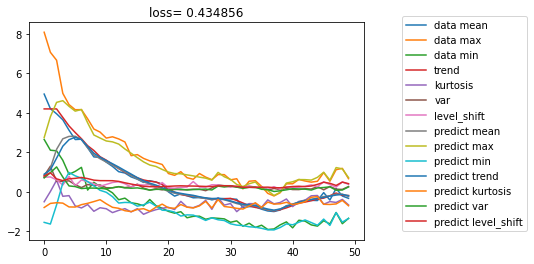

In [52]:
compare_seq(model_best, test_seq.data[0])

In [12]:
def get_original_ts(data, data_type):
    """
    Recreate the original time serie leaving the overlapping part of the seq since the last part are the begnning of the decoding
    keeping the first element give more potential error on prediction
    """
    last_values = size_window - step_window
    if data_type=='train':
        nb_ts_origine=1677
    elif data_type=='test':
        nb_ts_origine=2511
    return torch.cat((data[:, :step_window, :].reshape(nb_ts_origine, -1, nb_feature),
                          data.reshape(nb_ts_origine, -1, nb_feature)[:,-last_values:,:]),
                          axis=1)

Example on a bad prediction (constant variable)

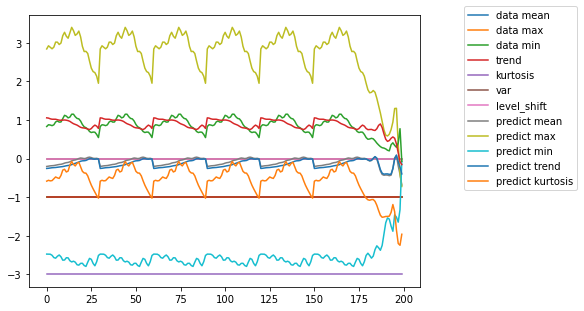

In [19]:
ind=2379
plt.figure(figsize=(7,5))
plt.plot(get_original_ts(test_seq.data, data_type='test')[ind])
plt.plot(get_original_ts(test_pred, data_type='test')[ind]);
plt.legend(['data mean', 'data max', 'data min', 'trend', 'kurtosis', 'var', 'level_shift',
                      'predict mean', 'predict max', "predict min", 'predict trend', 'predict kurtosis', 'predict var'],
                      bbox_to_anchor=(1.1, 1.05));

In [28]:
#Retrieve the ordered train and valid data set
train_loader_pred = DataLoader(train_seq, batch_size, shuffle=False)
valid_loader_pred = DataLoader(valid_seq, batch_size, shuffle=False)

In [29]:
# train_pred = predict(train_loader_pred, train_seq.data, model_best)
train_pred = get_avg_pred(train_loader_pred, train_seq.data, model_best)

====> Prediction Average loss: 0.016964
====> Prediction Average loss: 0.016965
====> Prediction Average loss: 0.016960
====> Prediction Average loss: 0.016966
====> Prediction Average loss: 0.016969
====> Prediction Average loss: 0.016959
====> Prediction Average loss: 0.016968
====> Prediction Average loss: 0.016977
====> Prediction Average loss: 0.016963
====> Prediction Average loss: 0.016970
====> Prediction Average loss: 0.016967


In [30]:
# valid_pred = predict(valid_loader_pred, valid_seq.data, model_best)
valid_pred = get_avg_pred(valid_loader_pred, valid_seq.data, model_best)

====> Prediction Average loss: 0.033824
====> Prediction Average loss: 0.033771
====> Prediction Average loss: 0.033826
====> Prediction Average loss: 0.033757
====> Prediction Average loss: 0.033855
====> Prediction Average loss: 0.033804
====> Prediction Average loss: 0.033788
====> Prediction Average loss: 0.033800
====> Prediction Average loss: 0.033829
====> Prediction Average loss: 0.033817
====> Prediction Average loss: 0.033816


In [31]:
full_train_pred = torch.cat([train_pred, valid_pred], dim=0)

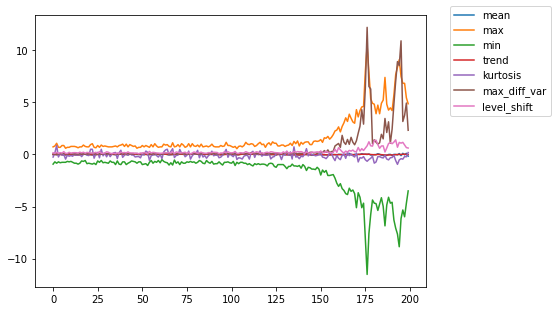

In [56]:
ind=0
plt.figure(figsize=(7,5))
plt.plot(get_original_ts(torch.cat([train_seq.data, valid_seq.data], dim=0), data_type='train')[ind]);
plt.legend(['mean', 'max', 'min', 'trend', 'kurtosis', 'max_diff_var', 'level_shift'],
          bbox_to_anchor=(1.05, 1.05));

## Reconstruction Erreur par Série

In [36]:
def calcul_score_serie(data, predict, data_type, calc_type='max'):
    """
    Calculate the error of prediction with different possible technique
    """
    if data_type=='train':
        nb_ts_origine=1677
    elif data_type=='test':
        nb_ts_origine=2511
    else:
        raise ValueError('data_type value is wrong: ', data_type)
    if calc_type=='mean':
        loss =  torch.pow(torch.add(get_original_ts(data, data_type=data_type),
                                  get_original_ts(-predict, data_type=data_type)),
                         2).numpy()
        loss = np.mean(loss, axis=1)
        return loss
    elif calc_type=='abs_mean':
        loss = (torch.div(get_original_ts(-predict, data_type=data_type), 
                        get_original_ts(data, data_type=data_type)+1*10**-8) -1).numpy()
        loss = np.mean(loss, axis=1)
        return loss
    elif calc_type=='cos_similarity':
        loss = np.zeros((nb_ts_origine, data.shape[2]))
        for i in range(data.shape[2]):
            loss[:, i] = 1 - np.mean(cosine_similarity(get_original_ts(data, data_type=data_type).numpy()[:, :, i], get_original_ts(predict, data_type=data_type).numpy()[:, :, i]), axis = 1)
        return loss
    else:
        raise ValueError('calc_type value is wrong: ', calc_type)

In [38]:
score_train = calcul_score_serie(torch.cat([train_seq.data, valid_seq.data], dim=0), full_train_pred, data_type='train', calc_type='mean')

In [39]:
score_test = calcul_score_serie(test_seq.data, test_pred, data_type='test', calc_type='mean')

## Add additional features:

In [32]:
train_feat = score_train
test_feat = score_test

In [33]:
def add_new_feature(train, test, list_feat):
    list_concat_train = [train]
    list_concat_test = [test]
    if 'acf' in list_feat:
        list_concat_train.append(torch.load('../data/train_acf.pt').numpy().reshape(-1, 1))        
        list_concat_test.append(torch.load('../data/test_acf.pt').numpy().reshape(-1, 1))
    if 'skew' in list_feat:
        list_concat_train.append(torch.load('../data/train_skew.pt').numpy().reshape(-1, 1))        
        list_concat_test.append(torch.load('../data/test_skew.pt').numpy().reshape(-1, 1))
    if 'mean' in list_feat:
        list_concat_train.append(torch.load('../data/train_mean.pt').numpy().reshape(-1, 1))        
        list_concat_test.append(torch.load('../data/test_mean.pt').numpy().reshape(-1, 1))
    if 'crossing_points' in list_feat:
        list_concat_train.append(torch.load('../data/crossing_points_train.pt').numpy().reshape(-1, 1))      
        list_concat_test.append(torch.load('../data/crossing_points_test.pt').numpy().reshape(-1, 1))
    if 'flat_spots' in list_feat:
        list_concat_train.append(torch.load('../data/flat_spots_train.pt').numpy().reshape(-1, 1))     
        list_concat_test.append(torch.load('../data/flat_spots_test.pt').numpy().reshape(-1, 1))
    if 'hurst' in list_feat:
        list_concat_train.append(torch.load('../data/hurst_train.pt').numpy().reshape(-1, 1))        
        list_concat_test.append(torch.load('../data/hurst_test.pt').numpy().reshape(-1, 1))
    if 'spike' in list_feat:
        list_concat_train.append(torch.load('../data/spike_train.pt').numpy().reshape(-1, 1))        
        list_concat_test.append(torch.load('../data/spike_test.pt').numpy().reshape(-1, 1))
    if 'curvature' in list_feat:
        list_concat_train.append(torch.load('../data/curvature_train.pt').numpy().reshape(-1, 1))        
        list_concat_test.append(torch.load('../data/curvature_test.pt').numpy().reshape(-1, 1))
    if 'nonlinearity' in list_feat:
        list_concat_train.append(torch.load('../data/nonlinearity_train.pt').numpy().reshape(-1, 1))        
        list_concat_test.append(torch.load('../data/nonlinearity_test.pt').numpy().reshape(-1, 1))
    if 'diff1_acf10' in list_feat:
        list_concat_train.append(torch.load('../data/diff1_acf10_train.pt').numpy().reshape(-1, 1))      
        list_concat_test.append(torch.load('../data/diff1_acf10_test.pt').numpy().reshape(-1, 1))
    train_feat =  np.concatenate(list_concat_train, axis=1)
    test_feat =  np.concatenate(list_concat_test, axis=1) 
    return train_feat, test_feat

In [ ]:
list_feat = ['acf', 'skew', 'mean', 'crossing_points', 'flat_spots', 'hurst', 
             'spike', 'curvature', 'nonlinearity', 'diff1_acf10']
train_feat, test_feat = add_new_feature(score_train, score_test, list_feat)

## Anomaly Score Calculation

### Isolation Forest

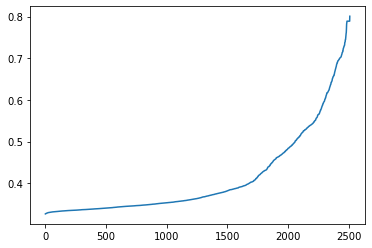

In [46]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=50, random_state=0).fit(train_feat)
predict_score = -clf.score_samples(test_feat)
plt.plot(np.sort(predict_score))

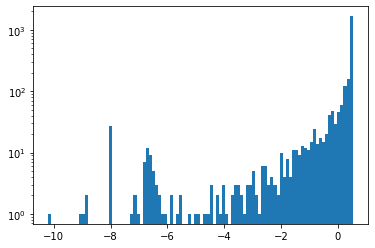

In [397]:
plt.hist(clf.decision_function(test_feat), bins=100)
plt.yscale('log')

## Submission

In [47]:
np.savetxt('ytest_challenge_student.csv', predict_score, fmt = '%1.6f', delimiter=',')

In [48]:
! zip submit.zip ytest_challenge_student.csv

updating: ytest_challenge_student.csv (deflated 62%)
